In [1]:
import numpy as np
import pandas as pd
import sys
import importlib
from tqdm import tqdm

import functools
import numba as nb
from rdkit import Chem, DataStructs, RDLogger
import pyteomics.mgf
import spectrum_utils.spectrum as sus
from matchms.filtering import normalize_intensities

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

sys.path.append("../../src/ms_similarity_metrics")
import frequency
import similarity_weighted as similarity
importlib.reload(frequency)
importlib.reload(similarity)

<module 'similarity_weighted' from '/Users/chloe/Desktop/weighted-mod-cosine-sim/notebooks/network_method/../../src/ms_similarity_metrics/similarity_weighted.py'>

In [1]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')   

# Get spectra data

In [2]:
# Spectra and spectrum pairs to include with the following settings.
charges = 0, 1
min_n_peaks = 6
fragment_mz_tolerance = 0.1
min_mass_diff = 1    # Da
max_mass_diff = 200    # Da

In [3]:
# Profile spectra contain 0 intensity values.
@nb.njit
def is_centroid(intensity_array):
    return np.all(intensity_array > 0)
            

# Convert smiles to mol
@functools.lru_cache
def _smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

# Assumes that the spectra are sorted by ascending precusor m/z.
@nb.njit
def generate_pairs(
    spectrum_indexes, masses, min_mass_diff, max_mass_diff
):
    for i in range(len(spectrum_indexes)):
        j = i + 1
        while (
            j < len(spectrum_indexes) and
            masses[j] - masses[i] < min_mass_diff
        ):
            j += 1
        while (
            j < len(spectrum_indexes) and
            masses[j] - masses[i] < max_mass_diff
        ):
            yield spectrum_indexes[i]
            yield spectrum_indexes[j]
            j += 1
    
# Function for calulating tanimoto scores
@functools.lru_cache
def tanimoto(smiles1, smiles2):
    mol1, mol2 = _smiles_to_mol(smiles1), _smiles_to_mol(smiles2)
    if mol1 is None or mol2 is None:
        return np.nan
    fp1, fp2 = Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [4]:
# Read all spectra from the MGF.
# ALL_GNPS_NO_PROPOGATED (retrieved on 2022-05-12) downloaded from
# https://gnps-external.ucsd.edu/gnpslibrary

# Spectrum quality filtering:
#   - Don't include propagated spectra (LIBRARYQUALITY==4).
#   - Don't include multiply charged molecules.
#   - Don't include spectra with invalid precursor m/z (0).
#   - Don't include spectra with too few peaks (minimum 6).
#   - Only include positive ion mode spectra.
#   - Only include spectra with [M+H]+ adducts.
#   - Only include centroid data (does not contain zero intensity values).
#   - Only include spectra with InChI and/or SMILES specified.

spectra = []
# Download from https://zenodo.org/record/6829249/files/ALL_GNPS_NO_PROPOGATED.mgf?download=1
filename = ("../../data/ALL_GNPS_NO_PROPOGATED.mgf")

with pyteomics.mgf.MGF(filename) as f_in:
    for spectrum_dict in tqdm(f_in):
        if (
            int(spectrum_dict["params"]["libraryquality"]) <= 3 and
            int(spectrum_dict["params"]["charge"][0]) in charges and
            float(spectrum_dict["params"]["pepmass"][0]) > 0 and
            len(spectrum_dict["m/z array"]) >= min_n_peaks and
            spectrum_dict["params"]["ionmode"] == "Positive" and
            spectrum_dict["params"]["name"].rstrip().endswith(" M+H") and
            is_centroid(spectrum_dict["intensity array"]) and
            (
                spectrum_dict["params"]["inchi"] != "N/A" or
                spectrum_dict["params"]["smiles"] != "N/A"
            )
        ):
            spec = sus.MsmsSpectrum(
                spectrum_dict["params"]["spectrumid"],
                float(spectrum_dict["params"]["pepmass"][0]),
                # Re-assign charge 0 to 1.
                max(int(spectrum_dict["params"]["charge"][0]), 1),
                spectrum_dict["m/z array"],
                spectrum_dict["intensity array"]/max(spectrum_dict["intensity array"]),
            )
            spec.library = spectrum_dict["params"]["organism"]
            spec.inchi = spectrum_dict["params"]["inchi"]
            spec.smiles = spectrum_dict["params"]["smiles"]
            spec.remove_precursor_peak(0.1, "Da")
            spec.filter_intensity(0.01, max_num_peaks=200)
            spectra.append(spec)


495600it [01:07, 7315.08it/s] 


In [5]:
# Round mz to 1 decimal
for s in spectra:
    s.mz.round(1, out=s.mz)

In [6]:
# Read in Wout metadata
metadata = pd.read_csv(
    'https://zenodo.org/record/6829249/files/gnps_libraries_metadata.csv?download=1'
)

# Get frequency data

In [7]:
# Get pair subset that Wout used
with open('../../data/Wout_data/pairs_subset.txt', 'r') as f:
    pairs_subset = f.read().splitlines()
    pairs_subset = pairs_subset[1:]
    pairs_subset = [np.array(pair.split(' ')).astype(int) for pair in pairs_subset]
pairs_subset = np.array(pairs_subset)

In [8]:
# Get dataframe containing m/z frequency information
frequency_df = pd.read_csv('../../data/Wout_data/frequency_df.csv')

# Get number of spectra used to generate the frequency_df
with open('../../data/Wout_data/num_spectra.txt', 'r') as f:
    num_spectra = int(f.read())

In [9]:
# Get frequency counts
with open('../../data/Wout_data/frequency_count.txt', 'r') as f:
    frequency_count = f.read().splitlines()
    frequency_count = frequency_count[1:]
    frequency_count = [float(x) for x in frequency_count]

In [42]:
# Get sample of pairs
np.random.seed(1)
#small_sample = pairs_subset[np.random.choice(pairs_subset.shape[0], 1_000_000, replace=False)]
small_sample = pairs_subset.copy()

# Get weights

In [43]:
# Define weight functions
idf_dict = frequency.idf(frequency_df, num_spectra, frequency_col='frequency')
weight_func = lambda x: np.exp(-x)+1/2
intensity_weight_func = lambda x: x**(1/4)
# Get dataframe of weights for m/z frequency
weight_df = frequency.get_weights(frequency_df, weight_func, weight_col='prob')


# # Define weight functions without mz
# idf_dict = frequency.idf(frequency_df, num_spectra, frequency_col='frequency')
# weight_func = lambda x: 1
# intensity_weight_func = lambda x: x**(1/4)
# # Get dataframe of weights for m/z frequency
# weight_df = frequency.get_weights(frequency_df, weight_func, weight_col='prob')

# # Define binary weights
# idf_dict = frequency.idf(frequency_df, num_spectra, frequency_col='frequency')
# weight_func = lambda x: 1
# intensity_weight_func = lambda x: np.ones(len(x))
# # Get dataframe of weights for m/z frequency
# weight_df = frequency.get_weights(frequency_df, weight_func, weight_col='prob')

# #Define Stein weights
# mz_weight_func = lambda x: x**(1.3)
# intensity_weight_func = lambda x: x**(0.53)
# # Get dataframe of weights for m/z frequency
# weight_df = frequency.get_weights(frequency_df, mz_weight_func, weight_col='prob')
# # Create stein_weight_df
# stein_weight_df = pd.DataFrame(index=weight_df.index.values, columns=['mz', 'weight'])
# stein_weight_df['mz'] = weight_df['mz'].copy()
# stein_weight_df['weight'] = weight_df['mz'].apply(lambda x: mz_weight_func(x))
# weight_df = stein_weight_df.copy()

# Get similarities

In [44]:
# Compute similarities between spectrum pairs.
weight_scores = []
mod_scores = []
neutral_loss_scores = []
for i, j in tqdm(small_sample):

    # Get weighted and modified cosine similarity
    weight_cos = similarity.weighted_modified_cosine(spectra[i], spectra[j], fragment_mz_tolerance, 
                                                     weight_df, intensity_weight_func=intensity_weight_func)
    mod_cos = similarity.modified_cosine(spectra[i], spectra[j], fragment_mz_tolerance)

    # save scores
    tan = tanimoto(metadata.at[i, "smiles"], metadata.at[j, "smiles"])
    weight_scores.append((weight_cos[0], weight_cos[1], tan))
    mod_scores.append((mod_cos[0], mod_cos[1], tan))

# save score information
similarities = pd.DataFrame(
    {
        "pair1": small_sample[:, 0],
        "pair2": small_sample[:, 1],
        "id1": metadata.loc[small_sample[:, 0], "id"].values,
        "id2": metadata.loc[small_sample[:, 1], "id"].values,
        "smiles1": metadata.loc[small_sample[:, 0], "smiles"].values,
        "smiles2": metadata.loc[small_sample[:, 1], "smiles"].values,
        "charge1": metadata.loc[small_sample[:, 0], "charge"].values,
        "charge2": metadata.loc[small_sample[:, 1], "charge"].values,
        "mz1": metadata.loc[small_sample[:, 0], "mz"].values,
        "mz2": metadata.loc[small_sample[:, 1], "mz"].values,
    }
)

similarities[
    [
        "weighted_modified_cosine",
        "weighted_modified_cosine_explained",
        "tanimoto",
    ]
] = weight_scores

similarities[
    [
        "modified_cosine",
        "modified_cosine_explained",
        "tanimoto",
    ]
] = mod_scores

    

  0%|                                | 3431/10000000 [00:08<6:25:27, 432.24it/s][09:59:27] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[09:59:27] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  0%|                                | 4156/10000000 [00:10<6:53:10, 403.21it/s][09:59:29] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[09:59:29] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  0%|                               | 16301/10000000 [00:40<6:46:57, 408.87it/s][09:59:58] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[09:59:58] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

  1%|▏                              | 62237/10000000 [02:29<6:35:44, 418.52it/s][10:01:48] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:01:48] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  1%|▏                              | 80574/10000000 [03:13<6:35:12, 418.32it/s][10:02:32] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:02:32] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  1%|▎                              | 81243/10000000 [03:15<6:28:07, 425.93it/s][10:02:34] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

  2%|▌                             | 167395/10000000 [06:38<6:15:14, 436.73it/s][10:05:57] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:05:57] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  2%|▌                             | 194053/10000000 [07:41<6:14:43, 436.13it/s][10:07:00] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:07:00] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  2%|▌                             | 198728/10000000 [07:52<6:22:06, 427.51it/s][10:07:11] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

  2%|▋                             | 242714/10000000 [09:37<6:23:16, 424.29it/s][10:08:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:08:56] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  2%|▋                             | 245115/10000000 [09:43<6:19:09, 428.79it/s][10:09:01] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:09:01] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  3%|▊                             | 262748/10000000 [10:24<6:08:14, 440.71it/s][10:09:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

  3%|▉                             | 311952/10000000 [12:21<6:24:49, 419.59it/s][10:11:40] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:11:40] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  3%|▉                             | 319167/10000000 [12:38<6:05:09, 441.86it/s][10:11:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:11:56] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  3%|▉                             | 327961/10000000 [12:58<6:19:05, 425.23it/s][10:12:17] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:12:17] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

  4%|█▏                            | 382105/10000000 [15:07<6:21:18, 420.40it/s][10:14:25] Explicit valence for atom # 22 N, 4, is greater than permitted
[10:14:26] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:14:26] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  4%|█▏                            | 405221/10000000 [16:01<6:15:40, 425.68it/s][10:15:20] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:15:20] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  4%|█▏                            | 408309/10000000 [16:09<6:31:59, 407.82it/s][10:15:27] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:15:27] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-

  5%|█▍                            | 468036/10000000 [18:30<5:49:20, 454.76it/s][10:17:48] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:17:48] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  5%|█▌                            | 506645/10000000 [19:58<5:28:15, 482.00it/s][10:19:16] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:19:16] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  5%|█▌                            | 535055/10000000 [21:00<6:07:08, 429.67it/s][10:20:19] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:20:19] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

  5%|█▌                            | 540813/10000000 [21:13<5:43:43, 458.66it/s][10:20:32] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:20:32] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  6%|█▋                            | 550906/10000000 [21:36<5:34:27, 470.86it/s][10:20:54] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:20:54] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  6%|█▋                            | 553278/10000000 [21:41<5:33:35, 471.96it/s][10:21:00] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:21:00] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

  6%|█▉                            | 636521/10000000 [24:51<6:05:38, 426.80it/s][10:24:10] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:24:10] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
[10:24:10] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/C(C1)O)/C)(C)C'
  7%|█▉                            | 657313/10000000 [25:39<5:41:16, 456.27it/s][10:24:58] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:24:58] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  7%|█▉                            | 657741/10000000 [25:40<5:51:43, 442.69it/s][

  7%|██                            | 696931/10000000 [27:10<5:58:59, 431.90it/s][10:26:29] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:26:29] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  7%|██                            | 702170/10000000 [27:22<6:14:14, 414.07it/s][10:26:41] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:26:41] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  7%|██                            | 706569/10000000 [27:33<5:46:24, 447.14it/s][10:26:51] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

  8%|██▎                           | 761578/10000000 [29:36<5:45:30, 445.63it/s][10:28:55] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:28:55] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  8%|██▎                           | 774702/10000000 [30:06<5:39:00, 453.55it/s][10:29:25] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:29:25] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  8%|██▍                           | 804986/10000000 [31:13<5:31:42, 462.01it/s][10:30:31] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:30:31] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  8%|██▌                           | 837278/10000000 [32:23<5:27:08, 466.81it/s][10:31:42] SMILES Parse Error

  8%|██▌                           | 847034/10000000 [32:45<5:36:02, 453.96it/s][10:32:04] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:32:04] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  8%|██▌                           | 848725/10000000 [32:48<5:34:17, 456.26it/s][10:32:07] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:32:07] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  9%|██▋                           | 876185/10000000 [48:43<5:40:42, 446.31it/s][10:48:02] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:48

  9%|██▋                           | 907115/10000000 [49:53<5:51:58, 430.56it/s][10:49:12] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:49:12] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  9%|██▋                           | 908292/10000000 [49:55<5:48:53, 434.30it/s][10:49:14] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:49:14] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  9%|██▊                           | 917846/10000000 [50:17<6:32:37, 385.53it/s][10:49:36] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:49:36] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
  9%|██▊                           | 921708/10000000 [50:26<5:30:07, 458.32it/s][10:49:45] SMILES Parse Error

 10%|██▉                           | 999505/10000000 [53:23<5:36:46, 445.43it/s][10:52:42] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[10:52:42] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 10%|██▉                          | 1012086/10000000 [53:52<6:07:06, 408.04it/s][10:53:11] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:53:11] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 10%|██▉                          | 1015628/10000000 [54:00<5:11:40, 480.44it/s][10:53:19] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 11%|███                          | 1072485/10000000 [56:10<5:33:48, 445.75it/s][10:55:29] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:55:29] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 11%|███▏                         | 1093428/10000000 [56:57<5:26:27, 454.71it/s][10:56:16] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:56:16] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 12%|███▎                         | 1155224/10000000 [59:18<5:28:29, 448.76it/s][10:58:37] Explicit valence for atom # 22 N, 4, is greater than permitted
[10:58:37] Explicit valence for atom # 35 O, 3, is greater than permitted
 12%|███▏                       | 1176117/10000000 [1:00:05<5:23:07, 455.14it/s][10:59:23] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[10:59:23] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 12%|███▏                       | 1186226/10000000 [1:00:27<5:30:12, 444.85it/s][10:59:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18

 13%|███▍                       | 1279197/10000000 [1:03:57<5:28:56, 441.86it/s][11:03:15] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:03:15] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 13%|███▍                       | 1290594/10000000 [1:04:22<5:06:58, 472.85it/s][11:03:41] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:03:41] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 13%|███▌                       | 1304710/10000000 [1:04:53<5:12:03, 464.42it/s][11:04:12] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:04:12] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 13%|███▌                       | 1315057/10000000 [1:05:16<5:22:29, 448.85it/s][11:04:35] Explicit valence f

 13%|███▌                       | 1316121/10000000 [1:05:19<5:28:48, 440.18it/s][11:04:38] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:04:38] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 13%|███▌                       | 1316817/10000000 [1:05:20<5:13:10, 462.12it/s][11:04:39] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:04:39] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 13%|███▌                       | 1335041/10000000 [1:06:02<5:03:33, 475.74it/s][11:05:21] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:05:21] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 14%|███▊                       | 1403658/10000000 [1:08:39<5:23:05, 443.45it/s][11:07:57] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:07:57] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 14%|███▊                       | 1408435/10000000 [1:08:49<5:13:14, 457.13it/s][11:08:08] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:08:08] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 14%|███▊                       | 1430958/10000000 [1:09:40<5:08:21, 463.15it/s][11:08:59] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:08

 15%|███▉                       | 1465878/10000000 [1:11:00<5:37:46, 421.09it/s][11:10:18] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:10:18] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 15%|████                       | 1483240/10000000 [1:11:39<5:30:47, 429.12it/s][11:10:58] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:10:58] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 15%|████                       | 1483857/10000000 [1:11:40<5:19:33, 444.17it/s][11:10:59] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:10:59] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 15%|████                       | 1518107/10000000 [1:12:57<5:03:19, 466.05it/s][11:12:16] SMILES Parse Error

 16%|████▏                      | 1571724/10000000 [1:14:56<5:27:37, 428.76it/s][11:14:15] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:14:15] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 16%|████▎                      | 1580057/10000000 [1:15:16<5:26:25, 429.91it/s][11:14:34] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:14:34] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 16%|████▍                      | 1626573/10000000 [1:17:02<5:28:25, 424.94it/s][11:16:21] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:16:21] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 16%|████▍                      | 1645746/10000000 [1:17:45<5:09:33, 449.79it/s][11:17:03] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:17:03] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 17%|████▌                      | 1699309/10000000 [1:19:44<4:56:25, 466.70it/s][11:19:02] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:19:02] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 17%|████▌                      | 1709597/10000000 [1:20:06<5:02:44, 456.39it/s][11:19:25] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:19:25] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 18%|████▊                      | 1770677/10000000 [1:22:19<4:42:03, 486.26it/s][11:21:37] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:21:37] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 18%|████▊                      | 1785870/10000000 [1:22:52<5:00:14, 455.98it/s][11:22:11] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:22:11] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 18%|████▊                      | 1791655/10000000 [1:23:05<5:09:41, 441.74it/s][11:22:23] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 18%|████▉                      | 1829203/10000000 [1:24:28<5:09:04, 440.61it/s][11:23:47] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:23:47] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 18%|████▉                      | 1838274/10000000 [1:24:49<5:00:19, 452.93it/s][11:24:08] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:24:08] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 30%|████████▏                  | 3031563/10000000 [2:09:33<4:23:06, 441.43it/s][12:08:52] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:08:52] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 30%|████████▏                  | 3038355/10000000 [2:09:48<4:31:45, 426.95it/s][12:09:07] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:09:07] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 30%|████████▏                  | 3046333/10000000 [2:10:06<4:28:31, 431.60it/s][12:09:25] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:09:25] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 30%|████████▏                  | 3048929/10000000 [2:10:12<4:16:52, 451.01it/s][12:09:31] SMILES Parse Error

 31%|████████▎                  | 3085193/10000000 [2:11:34<4:22:08, 439.63it/s][12:10:53] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:10:53] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 31%|████████▎                  | 3086525/10000000 [2:11:37<4:22:13, 439.41it/s][12:10:55] SMILES Parse Error: unclosed ring for input: 'C\CC[C@@]2([C@@H](O2)CC(/C=C/C1=O)(C)C)C'
[12:10:55] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
 31%|████████▎                  | 3089449/10000000 [2:11:43<4:18:10, 446.11it/s][12:11:02] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:11:02] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-

 32%|████████▌                  | 3165237/10000000 [2:14:34<4:11:56, 452.13it/s][12:13:53] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:13:53] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 32%|████████▋                  | 3201976/10000000 [2:15:59<4:15:35, 443.28it/s][12:15:18] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:15:18] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 32%|████████▋                  | 3226410/10000000 [2:16:54<3:55:47, 478.77it/s][12:16:13] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:16:13] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 32%|████████▋                  | 3238730/10000000 [2:17:22<4:18:22, 436.14it/s][12:16:41] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:16:41] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
[12:16:41] Explicit valence for atom # 19 N, 4, is greater than permitted
 32%|████████▊                  | 3243195/10000000 [2:17:33<4:17:34, 437.19it/s][12:16:51] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:16:51] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(

 33%|████████▉                  | 3315514/10000000 [2:20:17<4:17:59, 431.82it/s][12:19:35] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:19:35] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 33%|████████▉                  | 3322785/10000000 [2:20:33<4:10:42, 443.89it/s][12:19:52] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:19:52] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/C(C1)O)/C)(C)C'
 33%|████████▉                  | 3331891/10000000 [2:20:54<4:29:04, 413.02it/s][12:20:13] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:20:13] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 33%|█████████                  | 3336783/10000000 [2:21:05<4:12:38, 439.58it/s][12:20:24] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=

 34%|█████████▏                 | 3390963/10000000 [2:23:09<4:02:29, 454.26it/s][12:22:28] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:22:28] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 34%|█████████▏                 | 3398605/10000000 [2:23:26<4:07:25, 444.66it/s][12:22:45] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:22:45] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 34%|█████████▏                 | 3398697/10000000 [2:23:26<4:04:06, 450.72it/s][12:22:45] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:22:45] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 35%|█████████▎                 | 3468690/10000000 [2:26:04<4:10:28, 434.58it/s][12:25:23] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:25:23] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 35%|█████████▍                 | 3477606/10000000 [2:26:24<3:37:52, 498.94it/s][12:25:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:25:43] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 36%|█████████▋                 | 3567196/10000000 [2:29:44<4:19:47, 412.69it/s][12:29:03] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
[12:29:03] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/CC1)/C)(C)C'
 36%|█████████▋                 | 3567788/10000000 [2:29:46<4:09:30, 429.66it/s][12:29:05] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:29:05] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 36%|█████████▋                 | 3572615/10000000 [2:29:57<4:09:47, 428.84it/s][12:29:16] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:29:16] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O

 36%|█████████▋                 | 3604391/10000000 [2:31:08<3:56:20, 451.01it/s][12:30:27] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:30:27] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 36%|█████████▊                 | 3625312/10000000 [2:31:55<3:57:42, 446.96it/s][12:31:14] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:31:14] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 37%|██████████                 | 3712661/10000000 [2:35:09<3:42:32, 470.87it/s][12:34:28] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:34:28] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 37%|██████████                 | 3714634/10000000 [2:35:13<3:49:50, 455.77it/s][12:34:32] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:34:32] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 37%|██████████                 | 3722280/10000000 [2:35:30<3:42:47, 469.61it/s][12:34:49] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 38%|██████████▏                | 3791928/10000000 [2:38:10<4:00:38, 429.98it/s][12:37:29] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:37:29] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 38%|██████████▎                | 3801328/10000000 [2:38:31<3:56:19, 437.14it/s][12:37:50] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:37:50] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 38%|██████████▎                | 3803996/10000000 [2:38:37<3:44:50, 459.30it/s][12:37:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:37

 39%|██████████▍                | 3876595/10000000 [2:41:21<3:45:00, 453.55it/s][12:40:40] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:40:40] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 39%|██████████▍                | 3883393/10000000 [2:41:36<3:35:23, 473.29it/s][12:40:55] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:40:55] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 40%|██████████▋                | 3958261/10000000 [2:44:25<3:49:05, 439.55it/s][12:43:44] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:43:44] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 40%|██████████▋                | 3958502/10000000 [2:44:26<3:38:41, 460.41it/s][12:43:45] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:43:45] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 40%|██████████▉                | 4028088/10000000 [2:47:05<3:41:56, 448.45it/s][12:46:23] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:46:24] Explicit valence for atom # 22 N, 4, is greater than permitted
 41%|██████████▉                | 4059513/10000000 [2:48:16<3:43:11, 443.59it/s][12:47:35] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:47:35] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 41%|██████████▉                | 4062930/10000000 [2:48:23<3:37:20, 455.28it/s][12:47:42] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:47:42] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)

 41%|███████████                | 4114426/10000000 [2:50:19<3:33:23, 459.70it/s][12:49:38] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:49:38] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 41%|███████████                | 4116384/10000000 [2:50:23<3:31:07, 464.45it/s][12:49:42] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:49:42] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 41%|███████████                | 4119953/10000000 [2:50:32<3:47:11, 431.36it/s][12:49:50] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:49:50] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 41%|███████████▏               | 4122217/10000000 [2:50:37<3:40:39, 443.96it/s][12:49:56] SMILES Parse Error

 42%|███████████▎               | 4188103/10000000 [2:53:06<3:36:28, 447.48it/s][12:52:25] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:52:25] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 42%|███████████▎               | 4200350/10000000 [2:53:33<3:38:52, 441.62it/s][12:52:52] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:52:52] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 42%|███████████▍               | 4215384/10000000 [2:54:07<3:47:28, 423.83it/s][12:53:26] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:53

 43%|███████████▌               | 4269854/10000000 [2:56:13<3:42:51, 428.53it/s][12:55:32] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:55:32] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 43%|███████████▌               | 4272160/10000000 [2:56:18<3:37:47, 438.33it/s][12:55:37] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:55:37] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 43%|███████████▌               | 4280548/10000000 [2:56:38<3:50:10, 414.13it/s][12:55:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:55

 44%|███████████▊               | 4362962/10000000 [2:59:43<3:32:41, 441.71it/s][12:59:02] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:59:02] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 44%|███████████▊               | 4368604/10000000 [2:59:56<3:28:33, 450.02it/s][12:59:15] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[12:59:15] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
[12:59:15] Explicit valence for atom # 22 O, 3, is greater than permitted
 44%|███████████▊               | 4369445/10000000 [2:59:58<3:22:22, 463.71it/s][12:59:17] Explicit valence for atom # 22 N, 4, is greater than permitted
[12:59:17] SMILES Parse Error: extra open parentheses for input: 'COC(=O)C1=CCCC2C3(C)CC(OC(=O)C3CC(OC3OC(CO)C(O)C(O)C3O'
 44%|███████████▊               | 4376683/10000000 [3:00

 44%|███████████▉               | 4429103/10000000 [3:02:11<3:26:57, 448.62it/s][13:01:30] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:01:30] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 44%|████████████               | 4445040/10000000 [3:02:47<3:16:19, 471.57it/s][13:02:06] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:02:06] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 44%|████████████               | 4445685/10000000 [3:02:49<3:29:53, 441.03it/s][13:02:08] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
[13:02:08] Explicit valence f

 45%|████████████▏              | 4502393/10000000 [3:04:56<3:42:02, 412.67it/s][13:04:15] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:04:15] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 45%|████████████▏              | 4505927/10000000 [3:05:05<3:24:12, 448.41it/s][13:04:24] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:04:24] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 46%|████████████▎              | 4566517/10000000 [3:07:21<3:18:35, 456.01it/s][13:06:40] SMILES Parse Error: unclosed ring for input: 'C\CC[C@@]2([C@@H](O2)CC(/C=C/C1=O)(C)C)C'
[13:06:40] SMILES Parse Error: extra open parentheses for input: 'COC(=O)C1=CCCC2C3(C)CC(OC(=O)C3CC(OC3OC(CO)C(O)C(O)C3O'
 46%|████████████▍              | 4587697/10000000 [3:08:09<3:21:39, 447.33it/s][13:07:28] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:07:28] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 46%|████████████▍              | 4589718/10000000 [3:08:13<3:14:38, 463.25it/s][13:07:32] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[1

 46%|████████████▌              | 4646314/10000000 [3:10:20<3:08:14, 474.01it/s][13:09:39] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:09:39] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 47%|████████████▌              | 4656077/10000000 [3:10:42<3:15:19, 456.00it/s][13:10:01] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:10:01] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 47%|████████████▊              | 4729656/10000000 [3:13:27<3:18:16, 443.00it/s][13:12:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:12:46] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 48%|████████████▉              | 4783120/10000000 [3:15:27<3:17:22, 440.50it/s][13:14:45] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:14:45] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 49%|█████████████              | 4854263/10000000 [3:18:04<3:09:47, 451.86it/s][13:17:23] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:17:23] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 49%|█████████████▏             | 4867223/10000000 [3:18:34<3:01:38, 470.98it/s][13:17:53] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:17:53] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 49%|█████████████▎             | 4910579/10000000 [3:20:11<3:29:03, 405.74it/s][13:19:30] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:19:30] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 49%|█████████████▎             | 4911484/10000000 [3:20:14<3:13:26, 438.41it/s][13:19:33] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:19:33] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 50%|█████████████▍             | 4979500/10000000 [3:22:47<3:08:33, 443.76it/s][13:22:06] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:22:06] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 50%|█████████████▌             | 5001378/10000000 [3:23:35<3:02:18, 456.97it/s][13:22:54] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:22:54] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 50%|█████████████▌             | 5002582/10000000 [3:23:38<3:04:51, 450.55it/s][13:22:57] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:22:57] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 51%|█████████████▊             | 5099967/10000000 [3:27:16<3:03:45, 444.42it/s][13:26:34] SMILES Parse Error: unclosed ring for input: 'C\CC[C@@]2([C@@H](O2)CC(/C=C/C1=O)(C)C)C'
[13:26:34] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:26:34] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 51%|█████████████▊             | 5109156/10000000 [3:27:36<2:58:21, 457.02it/s][13:26:55] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:26:55] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 51%|█████████████▊             | 5117721/10000000 [3:27:56<3:07:02, 435.06it/s][13:27:14] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:27:14] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 51%|█████

 51%|█████████████▊             | 5138383/10000000 [3:28:42<2:59:42, 450.88it/s][13:28:01] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:28:01] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 51%|█████████████▉             | 5148380/10000000 [3:29:05<2:58:53, 452.02it/s][13:28:24] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:28:24] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 52%|██████████████             | 5226555/10000000 [3:32:03<3:00:30, 440.73it/s][13:31:22] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:31:22] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 52%|██████████████▏            | 5232444/10000000 [3:32:16<2:55:26, 452.90it/s][13:31:35] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:31:35] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 52%|██████████████▏            | 5233246/10000000 [3:32:18<2:53:48, 457.08it/s][13:31:37] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/C(C1)O)/C)(C)C'
[

 53%|██████████████▎            | 5288046/10000000 [3:34:21<2:47:50, 467.90it/s][13:33:40] Explicit valence for atom # 22 N, 4, is greater than permitted
[13:33:40] Explicit valence for atom # 19 N, 4, is greater than permitted
 53%|██████████████▎            | 5289432/10000000 [3:34:24<2:51:20, 458.23it/s][13:33:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:33:43] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 53%|██████████████▎            | 5295238/10000000 [3:34:38<3:14:12, 403.76it/s][13:33:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:33:56] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)

 54%|██████████████▍            | 5360206/10000000 [3:37:04<2:49:18, 456.72it/s][13:36:23] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:36:23] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 54%|██████████████▌            | 5374839/10000000 [3:37:37<2:48:12, 458.28it/s][13:36:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:36:56] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 54%|██████████████▌            | 5375604/10000000 [3:37:39<2:52:25, 447.00it/s][13:36:57] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:36

 54%|██████████████▋            | 5433468/10000000 [3:39:48<2:42:36, 468.06it/s][13:39:07] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:39:07] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 54%|██████████████▋            | 5438163/10000000 [3:39:58<2:38:28, 479.76it/s][13:39:17] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:39:17] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 55%|██████████████▋            | 5461195/10000000 [3:40:49<2:47:37, 451.27it/s][13:40:08] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:40

 55%|██████████████▉            | 5526684/10000000 [3:43:16<2:48:50, 441.59it/s][13:42:35] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:42:35] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 56%|██████████████▉            | 5554553/10000000 [3:44:18<2:44:43, 449.80it/s][13:43:37] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:43:37] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 56%|███████████████▏           | 5635277/10000000 [3:47:20<2:50:27, 426.78it/s][13:46:38] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:46:38] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 56%|███████████████▏           | 5642501/10000000 [3:47:36<2:39:21, 455.71it/s][13:46:55] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:46:55] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 57%|███████████████▎           | 5663427/10000000 [3:48:23<2:30:20, 480.74it/s][13:47:41] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:47

 57%|███████████████▎           | 5690211/10000000 [3:49:22<2:53:34, 413.82it/s][13:48:41] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:48:41] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 57%|███████████████▎           | 5690938/10000000 [3:49:24<2:51:45, 418.12it/s][13:48:43] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:48:43] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 57%|███████████████▍           | 5714234/10000000 [3:50:18<2:22:35, 500.94it/s][13:49:36] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:49

 58%|███████████████▌           | 5775531/10000000 [3:52:36<2:41:48, 435.12it/s][13:51:55] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:51:55] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 58%|███████████████▋           | 5790531/10000000 [3:53:10<2:35:44, 450.50it/s][13:52:28] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:52:28] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 58%|███████████████▋           | 5792508/10000000 [3:53:14<2:35:53, 449.81it/s][13:52:33] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 58%|███████████████▊           | 5848083/10000000 [3:55:20<2:52:20, 401.52it/s][13:54:38] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:54:38] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 58%|███████████████▊           | 5849312/10000000 [3:55:22<2:27:58, 467.53it/s][13:54:41] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:54:41] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 59%|████████████████           | 5937615/10000000 [3:58:38<2:27:23, 459.36it/s][13:57:57] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:57:57] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 59%|████████████████           | 5943194/10000000 [3:58:51<2:42:39, 415.68it/s][13:58:09] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[13:58:09] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 59%|████████████████           | 5944896/10000000 [3:58:54<2:28:34, 454.87it/s][13:58:13] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[13:58:13] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 60%|████████████████▏          | 6007203/10000000 [4:01:15<2:27:58, 449.71it/s][14:00:34] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:00:34] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 60%|████████████████▎          | 6035719/10000000 [4:02:20<2:33:17, 431.04it/s][14:01:38] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:01:38] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 60%|████████████████▎          | 6039884/10000000 [4:02:29<2:31:57, 434.35it/s][14:01:47] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 61%|████████████████▍          | 6093773/10000000 [4:04:28<2:24:53, 449.31it/s][14:03:47] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:03:47] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 61%|████████████████▍          | 6095632/10000000 [4:04:32<2:25:24, 447.53it/s][14:03:51] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:03:51] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 61%|████████████████▌          | 6117308/10000000 [4:05:20<2:13:23, 485.11it/s][14:04:38] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 62%|████████████████▋          | 6174957/10000000 [4:18:57<2:14:06, 475.36it/s][14:18:16] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:18:16] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 62%|████████████████▋          | 6181269/10000000 [4:19:11<2:14:14, 474.10it/s][14:18:30] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:18:30] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 62%|████████████████▋          | 6186462/10000000 [4:19:23<2:21:53, 447.93it/s][14:18:42] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 62%|████████████████▊          | 6232785/10000000 [4:21:03<2:19:13, 450.97it/s][14:20:22] Explicit valence for atom # 35 O, 3, is greater than permitted
[14:20:22] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/CC1)/C)(C)C'
 62%|████████████████▊          | 6248010/10000000 [4:21:37<2:22:27, 438.94it/s][14:20:56] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:20:56] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 63%|████████████████▉          | 6271836/10000000 [4:22:29<2:13:29, 465.48it/s][14:21:48] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:21:48] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 63%|████████████████▉          | 6287157/10000000 [4:23:02<2:09:59, 476.03it/s][14:22:21] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
[14:22:21] SMIL

 63%|█████████████████          | 6327740/10000000 [4:24:31<2:16:09, 449.51it/s][14:23:50] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:23:50] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 63%|█████████████████          | 6331033/10000000 [4:24:38<2:07:40, 478.92it/s][14:23:57] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:23:57] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 63%|█████████████████▏         | 6342644/10000000 [4:25:04<2:12:29, 460.07it/s][14:24:23] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:24:23] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 63%|█████████████████▏         | 6348977/10000000 [4:25:17<2:08:53, 472.11it/s][14:24:36] SMILES Parse Error

 64%|█████████████████▎         | 6401309/10000000 [4:27:11<2:18:18, 433.68it/s][14:26:30] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:26:30] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 64%|█████████████████▎         | 6427378/10000000 [4:28:08<2:14:22, 443.11it/s][14:27:27] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:27:27] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 64%|█████████████████▍         | 6441975/10000000 [4:28:40<2:11:51, 449.70it/s][14:27:59] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:27

 65%|█████████████████▌         | 6489866/10000000 [4:30:25<2:04:36, 469.46it/s][14:29:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:29:43] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 65%|█████████████████▌         | 6515974/10000000 [4:31:21<2:12:54, 436.91it/s][14:30:40] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:30:40] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 66%|█████████████████▋         | 6558884/10000000 [4:32:54<2:00:07, 477.42it/s][14:32:13] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:32:13] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 66%|█████████████████▊         | 6575739/10000000 [4:33:31<1:56:42, 489.03it/s][14:32:50] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:32:50] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 67%|█████████████████▉         | 6664819/10000000 [4:36:50<2:02:24, 454.12it/s][14:36:09] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:36:09] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 67%|██████████████████         | 6677869/10000000 [4:37:20<2:00:01, 461.34it/s][14:36:39] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:36:39] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 67%|██████████████████         | 6689751/10000000 [4:37:47<2:00:56, 456.21it/s][14:37:06] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 67%|██████████████████▏        | 6736943/10000000 [4:39:31<1:56:56, 465.03it/s][14:38:50] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:38:50] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 67%|██████████████████▏        | 6738133/10000000 [4:39:33<2:06:12, 430.74it/s][14:38:52] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:38:52] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 68%|██████████████████▏        | 6755994/10000000 [4:40:14<1:58:19, 456.91it/s][14:39:33] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 68%|██████████████████▎        | 6803507/10000000 [4:42:01<2:04:11, 428.98it/s][14:41:20] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:41:20] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 68%|██████████████████▍        | 6808170/10000000 [4:42:11<1:51:11, 478.41it/s][14:41:30] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:41:30] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 69%|██████████████████▌        | 6874740/10000000 [4:44:43<1:57:23, 443.73it/s][14:44:02] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:44:02] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 69%|██████████████████▌        | 6875966/10000000 [4:44:45<2:02:02, 426.64it/s][14:44:04] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:44:04] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 69%|██████████████████▌        | 6878853/10000000 [4:44:52<1:49:29, 475.12it/s][14:44:11] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:44:11] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 69%|██████████████████▋        | 6927978/10000000 [4:46:43<1:59:26, 428.69it/s][14:46:02] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:46:02] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 69%|██████████████████▋        | 6932065/10000000 [4:46:53<2:06:14, 405.01it/s][14:46:11] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:46:11] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 70%|██████████████████▉        | 7000348/10000000 [4:49:25<1:46:08, 470.99it/s][14:48:44] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:48:44] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 70%|██████████████████▉        | 7000493/10000000 [4:49:26<1:47:06, 466.75it/s][14:48:44] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:48:44] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 70%|██████████████████▉        | 7011883/10000000 [4:49:51<2:01:43, 409.11it/s][14:49:10] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:49

 71%|███████████████████        | 7053418/10000000 [4:51:25<1:50:04, 446.12it/s][14:50:44] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:50:44] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 71%|███████████████████        | 7063250/10000000 [4:51:47<1:49:21, 447.56it/s][14:51:06] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:51:06] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 71%|███████████████████▏       | 7122582/10000000 [4:54:00<1:41:26, 472.76it/s][14:53:19] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 71%|███████████████████▎       | 7129983/10000000 [4:54:17<1:48:20, 441.54it/s][14:53:36] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:53:36] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 71%|███████████████████▎       | 7140822/10000000 [4:54:42<1:49:37, 434.72it/s][14:54:01] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:54:01] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 71%|███████████████████▎       | 7145007/10000000 [4:54:51<1:45:36, 450.55it/s][14:54:10] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[14:54:10] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 72%|███████████████████▎       | 7171171/10000000 [4:55:50<1:39:17, 474.85it/s][14:55:09] SMILES Parse Error

 72%|███████████████████▍       | 7209670/10000000 [4:57:16<1:43:56, 447.44it/s][14:56:35] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:56:35] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 72%|███████████████████▍       | 7210604/10000000 [4:57:18<1:44:18, 445.68it/s][14:56:37] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:56:37] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 73%|███████████████████▌       | 7266693/10000000 [4:59:26<1:50:03, 413.92it/s][14:58:45] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:58:45] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 73%|███████████████████▌       | 7267386/10000000 [4:59:27<1:50:23, 412.58it/s][14:58:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[14:58:46] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 73%|███████████████████▊       | 7343474/10000000 [5:02:21<1:38:45, 448.35it/s][15:01:40] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:01:40] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 73%|███████████████████▊       | 7345836/10000000 [5:02:26<1:41:30, 435.80it/s][15:01:45] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:01:45] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 74%|███████████████████▉       | 7363679/10000000 [5:03:07<1:35:04, 462.14it/s][15:02:26] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:02

 74%|████████████████████       | 7423823/10000000 [5:05:27<1:36:19, 445.72it/s][15:04:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:04:46] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 74%|████████████████████       | 7433079/10000000 [5:05:48<1:38:12, 435.65it/s][15:05:07] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:05:07] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 75%|████████████████████▏      | 7478810/10000000 [5:07:33<1:38:29, 426.62it/s][15:06:52] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:06:52] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 75%|████████████████████▏      | 7481699/10000000 [5:07:39<1:35:11, 440.93it/s][15:06:58] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:06:58] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 75%|████████████████████▎      | 7544693/10000000 [5:10:06<1:27:57, 465.20it/s][15:09:25] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:09:25] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 76%|████████████████████▍      | 7567239/10000000 [5:10:58<1:30:10, 449.61it/s][15:10:17] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:10:17] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 76%|████████████████████▌      | 7638603/10000000 [5:13:39<1:29:54, 437.74it/s][15:12:58] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:12:58] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 76%|████████████████████▋      | 7647085/10000000 [5:13:58<1:25:34, 458.30it/s][15:13:17] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:13:17] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 77%|████████████████████▊      | 7720399/10000000 [5:16:44<1:25:34, 444.01it/s][15:16:03] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:16:03] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 77%|████████████████████▊      | 7721281/10000000 [5:16:46<1:26:21, 439.79it/s][15:16:05] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:16:05] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 77%|████████████████████▊      | 7729698/10000000 [5:17:06<1:31:37, 412.95it/s][15:16:25] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:16:25] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 77%|████████████████████▉      | 7734493/10000000 [5:17:16<1:32:49, 406.80it/s][15:16:35] SMILES Parse Error

 78%|█████████████████████      | 7782914/10000000 [5:19:06<1:22:47, 446.36it/s][15:18:25] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:18:25] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 78%|█████████████████████      | 7806372/10000000 [5:19:58<1:21:17, 449.75it/s][15:19:17] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:19:17] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 78%|█████████████████████▏     | 7826241/10000000 [5:20:44<1:18:16, 462.82it/s][15:20:03] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:20

 79%|█████████████████████▏     | 7857286/10000000 [5:21:54<1:16:59, 463.80it/s][15:21:13] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:21:13] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 79%|█████████████████████▏     | 7859438/10000000 [5:21:59<1:23:17, 428.36it/s][15:21:18] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:21:18] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 79%|█████████████████████▏     | 7860211/10000000 [5:22:01<1:29:22, 399.04it/s][15:21:20] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 79%|█████████████████████▍     | 7929037/10000000 [5:24:39<1:18:54, 437.45it/s][15:23:58] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:23:58] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 79%|█████████████████████▍     | 7934865/10000000 [5:24:53<1:20:02, 429.98it/s][15:24:12] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:24:12] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 79%|█████████████████████▍     | 7943314/10000000 [5:25:12<1:17:50, 440.39it/s][15:24:31] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 80%|█████████████████████▌     | 7999367/10000000 [5:27:18<1:12:23, 460.59it/s][15:26:37] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:26:37] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 80%|█████████████████████▌     | 8000878/10000000 [5:27:21<1:10:01, 475.77it/s][15:26:40] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:26:40] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 80%|█████████████████████▌     | 8001641/10000000 [5:27:23<1:13:26, 453.55it/s][15:26:42] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:26

 80%|█████████████████████▋     | 8045619/10000000 [5:29:01<1:20:09, 406.35it/s][15:28:20] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:28:20] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 81%|█████████████████████▋     | 8053636/10000000 [5:29:19<1:06:09, 490.29it/s][15:28:38] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:28:38] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 81%|█████████████████████▊     | 8084385/10000000 [5:30:29<1:10:31, 452.71it/s][15:29:47] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 81%|█████████████████████▉     | 8103630/10000000 [5:31:11<1:10:59, 445.23it/s][15:30:30] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:30:30] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 81%|█████████████████████▉     | 8105179/10000000 [5:31:15<1:11:28, 441.88it/s][15:30:34] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:30:34] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 81%|█████████████████████▉     | 8105882/10000000 [5:31:16<1:11:28, 441.72it/s][15:30:35] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 81%|██████████████████████     | 8148154/10000000 [5:32:53<1:09:17, 445.47it/s][15:32:12] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:32:12] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 82%|██████████████████████     | 8151811/10000000 [5:33:01<1:09:00, 446.38it/s][15:32:20] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:32:20] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 82%|██████████████████████     | 8153289/10000000 [5:33:04<1:07:11, 458.05it/s][15:32:23] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 82%|██████████████████████▏    | 8220072/10000000 [5:35:35<1:09:31, 426.67it/s][15:34:54] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:34:54] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 82%|██████████████████████▎    | 8249325/10000000 [5:36:42<1:09:52, 417.54it/s][15:36:00] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:36:00] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 83%|██████████████████████▎    | 8253682/10000000 [5:36:53<1:05:43, 442.87it/s][15:36:12] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:36

 83%|██████████████████████▍    | 8294402/10000000 [5:38:25<1:02:53, 452.01it/s][15:37:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:37:43] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 83%|██████████████████████▍    | 8318864/10000000 [5:39:21<1:05:19, 428.90it/s][15:38:40] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:38:40] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 83%|██████████████████████▍    | 8320750/10000000 [5:39:26<1:05:57, 424.31it/s][15:38:45] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:38

 84%|██████████████████████▌    | 8353553/10000000 [5:40:42<1:00:22, 454.51it/s][15:40:01] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:40:01] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 84%|██████████████████████▌    | 8372831/10000000 [5:41:26<1:04:37, 419.69it/s][15:40:45] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:40:45] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 84%|██████████████████████▋    | 8406437/10000000 [5:42:43<1:00:08, 441.64it/s][15:42:02] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 84%|██████████████████████▋    | 8425666/10000000 [5:43:27<1:00:54, 430.81it/s][15:42:46] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:42:46] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/C(C1)O)/C)(C)C'
 84%|████████████████████████▍    | 8437533/10000000 [5:43:54<59:28, 437.81it/s][15:43:13] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:43:13] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 85%|████████████████████████▌    | 8483171/10000000 [5:45:41<59:27, 425.17it/s][15:44:59] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:44:59] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-

 85%|████████████████████████▋    | 8510855/10000000 [5:46:43<57:45, 429.69it/s][15:46:02] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:46:02] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 85%|████████████████████████▋    | 8520506/10000000 [5:47:06<55:39, 442.99it/s][15:46:24] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:46:24] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 85%|████████████████████████▋    | 8523633/10000000 [5:47:13<56:27, 435.80it/s][15:46:31] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 86%|████████████████████████▉    | 8591256/10000000 [5:49:44<52:57, 443.31it/s][15:49:03] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:49:03] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 86%|████████████████████████▉    | 8610766/10000000 [5:50:28<51:52, 446.36it/s][15:49:47] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:49:47] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 86%|████████████████████████▉    | 8615410/10000000 [5:50:38<49:58, 461.81it/s][15:49:57] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 87%|█████████████████████████    | 8663593/10000000 [5:52:27<48:43, 457.08it/s][15:51:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:51:46] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 87%|█████████████████████████▏   | 8663878/10000000 [5:52:28<47:32, 468.34it/s][15:51:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:51:46] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 87%|█████████████████████████▎   | 8726472/10000000 [5:54:45<47:01, 451.35it/s][15:54:04] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:54:04] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 87%|█████████████████████████▎   | 8728617/10000000 [5:54:50<45:10, 469.09it/s][15:54:09] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[15:54:09] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 88%|█████████████████████████▍   | 8761301/10000000 [5:56:28<49:07, 420.20it/s][15:55:47] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:55:47] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 88%|███████████████████████▋   | 8785745/10000000 [5:57:25<1:22:03, 246.62it/s][15:56:44] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:56:44] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 88%|█████████████████████████▌   | 8814326/10000000 [5:58:31<43:19, 456.15it/s][15:57:50] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
[15:57:50] Explicit valence for atom # 19 N, 4, is greater than permitted
 88%|█████████████████████████▌   | 8817202/10000000 [5:58:38<49:14, 400.38it/s][15:57:56] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:57

 89%|█████████████████████████▋   | 8860764/10000000 [6:00:17<43:01, 441.38it/s][15:59:36] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[15:59:36] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 89%|█████████████████████████▋   | 8874602/10000000 [6:00:50<43:39, 429.69it/s][16:00:09] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:00:09] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 90%|██████████████████████████   | 8975119/10000000 [6:04:37<35:00, 488.00it/s][16:03:56] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:03:56] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 90%|██████████████████████████   | 8976131/10000000 [6:04:39<36:38, 465.67it/s][16:03:58] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:03:58] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 91%|██████████████████████████▎  | 9089753/10000000 [6:14:02<33:34, 451.84it/s][16:13:21] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:13:21] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 91%|██████████████████████████▍  | 9099655/10000000 [6:14:25<36:04, 415.92it/s][16:13:44] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:13:44] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 92%|██████████████████████████▌  | 9152600/10000000 [6:16:25<31:52, 443.01it/s][16:15:44] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:15:44] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 92%|██████████████████████████▌  | 9158383/10000000 [6:16:37<29:31, 474.98it/s][16:15:56] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:15:56] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 92%|██████████████████████████▌  | 9162560/10000000 [6:16:46<29:41, 470.13it/s][16:16:05] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-1

 92%|██████████████████████████▋  | 9210593/10000000 [6:18:35<29:07, 451.74it/s][16:17:53] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:17:53] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 92%|██████████████████████████▋  | 9211921/10000000 [6:18:37<29:06, 451.29it/s][16:17:56] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:17:56] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 92%|██████████████████████████▊  | 9238287/10000000 [6:19:39<29:57, 423.81it/s][16:18:58] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:18

 93%|██████████████████████████▉  | 9287937/10000000 [6:21:35<27:18, 434.54it/s][16:20:54] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:20:54] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 93%|██████████████████████████▉  | 9291423/10000000 [6:21:43<30:53, 382.29it/s][16:21:02] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:21:02] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 93%|██████████████████████████▉  | 9297468/10000000 [6:21:57<24:24, 479.85it/s][16:21:16] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:21:16] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 93%|███████████████████████████  | 9312966/10000000 [6:22:32<27:16, 419.83it/s][16:21:51] SMILES Parse Error

 93%|███████████████████████████  | 9338409/10000000 [6:23:30<26:52, 410.26it/s][16:22:49] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:22:49] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 94%|███████████████████████████▏ | 9360719/10000000 [6:24:21<24:58, 426.50it/s][16:23:40] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:23:40] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 94%|███████████████████████████▎ | 9414720/10000000 [6:26:24<21:57, 444.28it/s][16:25:43] SMILES Parse Error: unclosed ring for input: 'C\CC(/C=C/C(=O)/C(=C/CC1)/C)(C)C'
[16:25:43] Explicit valence for atom # 19 N, 4, is greater than permitted
 94%|███████████████████████████▍ | 9440810/10000000 [6:27:24<20:28, 455.25it/s][16:26:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:26:43] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 94%|███████████████████████████▍ | 9443742/10000000 [6:27:31<21:07, 438.85it/s][16:26:50] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:26:50] SMILES Parse Error: Failed parsing SMILES 'N/AC

 95%|███████████████████████████▌ | 9490769/10000000 [6:29:17<26:30, 320.12it/s][16:28:36] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:28:36] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 95%|███████████████████████████▌ | 9496612/10000000 [6:29:31<17:07, 490.09it/s][16:28:50] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:28:50] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 95%|███████████████████████████▋ | 9548727/10000000 [6:31:30<16:25, 457.96it/s][16:30:48] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:30:48] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 96%|███████████████████████████▋ | 9556404/10000000 [6:31:47<16:36, 445.02it/s][16:31:06] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:31:06] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 96%|███████████████████████████▋ | 9563703/10000000 [6:32:04<15:32, 467.93it/s][16:31:23] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:31

 96%|███████████████████████████▉ | 9615978/10000000 [6:34:02<14:39, 436.63it/s][16:33:21] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:33:21] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 96%|███████████████████████████▉ | 9627899/10000000 [6:34:29<14:13, 435.74it/s][16:33:48] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:33:48] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 97%|████████████████████████████ | 9692953/10000000 [6:36:57<11:55, 429.32it/s][16:36:16] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:36:16] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 97%|████████████████████████████▎| 9744232/10000000 [6:38:54<09:36, 443.50it/s][16:38:12] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:38:12] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 98%|████████████████████████████▎| 9767843/10000000 [6:39:47<08:22, 461.73it/s][16:39:06] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:39:06] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)

 98%|████████████████████████████▎| 9783709/10000000 [6:40:23<08:16, 435.41it/s][16:39:42] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:39:42] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 98%|████████████████████████████▍| 9789508/10000000 [6:40:36<07:48, 449.35it/s][16:39:55] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:39:55] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

 99%|████████████████████████████▌| 9863557/10000000 [6:43:24<05:07, 443.86it/s][16:42:43] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:42:43] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
 99%|████████████████████████████▋| 9873978/10000000 [6:43:47<04:36, 456.56it/s][16:43:06] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:43:06] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'
 99%|████████████████████████████▋| 9904253/10000000 [6:44:56<03:30, 454.31it/s][16:44:15] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[16:44

100%|████████████████████████████▊| 9955036/10000000 [6:46:50<01:42, 436.78it/s][16:46:09] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:46:09] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
100%|████████████████████████████▉| 9968106/10000000 [6:47:21<01:10, 452.34it/s][16:46:40] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[16:46:40] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12

In [45]:
# Normalize scores
if similarities['weighted_modified_cosine'].max() > 1:
    similarities['weighted_modified_cosine'] = similarities['weighted_modified_cosine']/similarities['weighted_modified_cosine'].max()
similarities['weighted_difference'] = abs(similarities['weighted_modified_cosine'] - similarities['modified_cosine'])

In [46]:
similarities["tanimoto_interval"] = pd.cut(
    similarities["tanimoto"],
    5,
    labels=["0.0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"],
)
similarities_tanimoto = pd.melt(
    similarities,
    id_vars="tanimoto_interval",
    value_vars=["weighted_modified_cosine", "modified_cosine"],
)

In [47]:
# Look at scores for tanimoto intervals
stats = similarities_tanimoto[similarities_tanimoto.variable != 'neutral_loss']
stats.groupby(['tanimoto_interval', 'variable']).agg(['mean', 'std'])


value          
                                                mean       std
tanimoto_interval variable                                    
0.0–0.2           modified_cosine           0.051430  0.119871
                  weighted_modified_cosine  0.109651  0.119971
0.2–0.4           modified_cosine           0.047774  0.106700
                  weighted_modified_cosine  0.116123  0.123929
0.4–0.6           modified_cosine           0.056668  0.124699
                  weighted_modified_cosine  0.126783  0.141689
0.6–0.8           modified_cosine           0.156509  0.245174
                  weighted_modified_cosine  0.234176  0.215950
0.8–1.0           modified_cosine           0.348152  0.364758
                  weighted_modified_cosine  0.353054  0.262326

In [48]:
# Look at mean difference between cosine scores and tanimoto scores
similarities['weighted_tanimoto_diff'] = abs(similarities['weighted_modified_cosine'] - similarities['tanimoto'])
similarities['modified_tanimoto_diff'] = abs(similarities['modified_cosine'] - similarities['tanimoto'])
print('mean difference between weighted cosine and tanimoto scores: ', similarities['weighted_tanimoto_diff'].mean())
print('mean difference between modified cosine and tanimoto scores: ', similarities['modified_tanimoto_diff'].mean())
similarities[['tanimoto_interval', 'weighted_tanimoto_diff', 'modified_tanimoto_diff']].groupby(['tanimoto_interval']).agg(['mean'])


mean difference between weighted cosine and tanimoto scores:  0.14656827095416827
mean difference between modified cosine and tanimoto scores:  0.17992085716137948


,weighted_tanimoto_diff,modified_tanimoto_diff
,mean,mean
tanimoto_interval,,
0.0–0.2,0.101435,0.113891
0.2–0.4,0.183014,0.242389
0.4–0.6,0.342433,0.415002
0.6–0.8,0.445603,0.540120
0.8–1.0,0.535810,0.560486


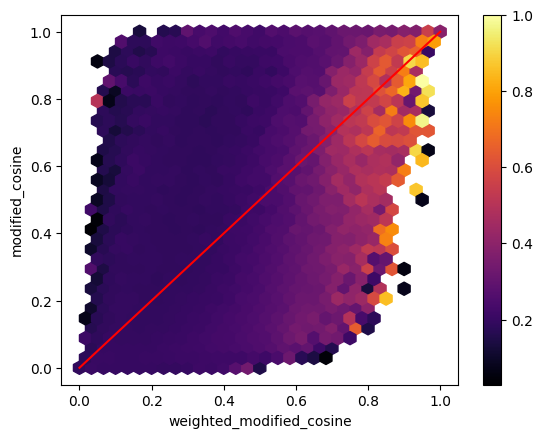

In [49]:
# Look at weighted vs. unweighted scores colored by tanimoto scores
similarities.plot.hexbin('weighted_modified_cosine', 'modified_cosine', C='tanimoto', gridsize=30, cmap='inferno')
plt.plot([0,1], [0,1], c='red')
plt.show()

# Show violin plots

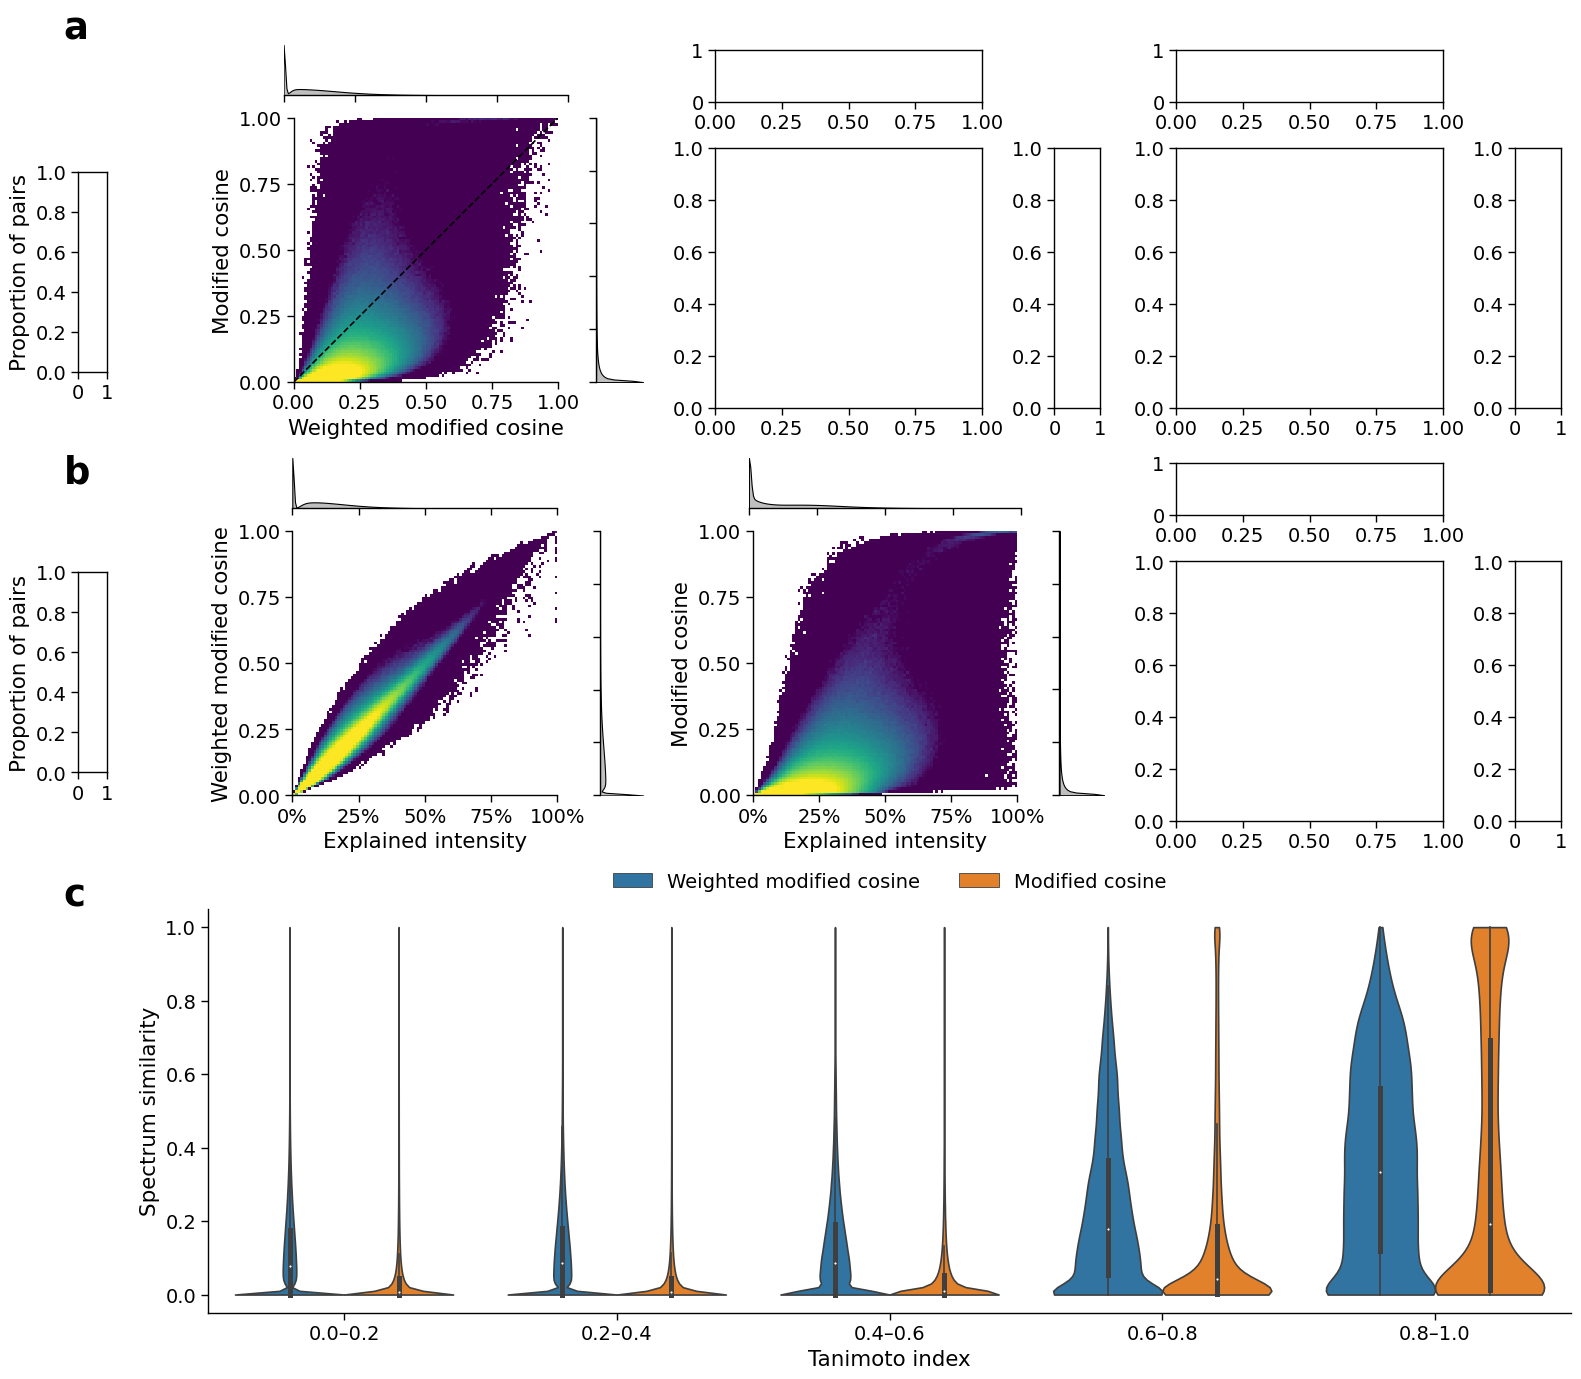

In [50]:
mosaic = """
11111.
222223
222223
222223
222223
222223
"""

bins = 100
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

with sns.plotting_context("paper", font_scale=1.6):
    fig = plt.figure(constrained_layout=True, figsize=(7.2 * 2, 7.2 / 1.618 * 3))
    gs = GridSpec(3, 3, figure=fig)
    
    # Top panel: Compare different similarities.
    axes_left = fig.add_subfigure(gs[0, 0]).subplot_mosaic(mosaic)
    axes_middle = fig.add_subfigure(gs[0, 1]).subplot_mosaic(mosaic)
    axes_right = fig.add_subfigure(gs[0, 2]).subplot_mosaic(mosaic)
    cbar_ax = fig.add_axes([-0.04, 0.75, 0.02, 0.15])
    
    labels = np.asarray([
        ["weighted_modified_cosine", "modified_cosine"],
    ])

    for i, (axes, (xlabel, ylabel)) in enumerate(
        zip([axes_left, axes_middle, axes_right], labels)
    ):
        # Plot heatmaps.
        hist, _, _ = np.histogram2d(
            similarities[xlabel],
            similarities[ylabel],
            bins=bins,
            range=[[0, 1], [0, 1]],
        )
        hist /= len(similarities)
        heatmap = sns.heatmap(
            np.rot90(hist),
            vmin=0.0,
            vmax=0.001,
            cmap="viridis",
            cbar=i == 2,
            cbar_kws={"format": mticker.StrMethodFormatter("{x:.3%}")},
            cbar_ax=cbar_ax if i == 2 else None,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes["2"],
            norm=LogNorm(vmin=0.00001,vmax=0.001),
        )
        axes["2"].yaxis.set_major_locator(tick_locators)
        axes["2"].set_yticklabels(tick_labels[::-1])
        axes["2"].xaxis.set_major_locator(tick_locators)
        axes["2"].set_xticklabels(tick_labels)
        for _, spine in heatmap.spines.items():
            spine.set_visible(True)
        axes["2"].set_xlabel(xlabel.replace("_", " ").capitalize())
        axes["2"].set_ylabel(ylabel.replace("_", " ").capitalize())

        axes["2"].plot(
            [0, bins], [bins, 0], color="black", linestyle="dashed"
        )

        sns.despine(ax=axes["2"])

        # Plot density plots.
        sns.kdeplot(
            data=similarities,
            x=xlabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["1"],
        )
        axes["1"].set_xlim(0, 1)
        axes["1"].xaxis.set_ticklabels([])
        axes["1"].yaxis.set_major_locator(tick_locators)
        axes["1"].set_yticks([])
        sns.despine(ax=axes["1"], left=True)
        sns.kdeplot(
            data=similarities,
            y=ylabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["3"],
        )
        axes["3"].set_ylim(0, 1)
        axes["3"].yaxis.set_ticklabels([])
        axes["3"].xaxis.set_major_locator(tick_locators)
        axes["3"].set_xticks([])
        sns.despine(ax=axes["3"], bottom=True)
        for ax in [axes[c] for c in "13"]:
            ax.set_xlabel("")
            ax.set_ylabel("")
            
    cbar_ax.set_ylabel("Proportion of pairs")
    cbar_ax.yaxis.set_label_position("left")
    # cbar_ax.spines["outline"].set(visible=True, lw=.8, edgecolor="black")
    
    # Middle panel: Compare similarities vs explained intensity.
    axes_left = fig.add_subfigure(gs[1, 0]).subplot_mosaic(mosaic)
    axes_middle = fig.add_subfigure(gs[1, 1]).subplot_mosaic(mosaic)
    axes_right = fig.add_subfigure(gs[1, 2]).subplot_mosaic(mosaic)
    cbar_ax = fig.add_axes([-0.04, 0.45, 0.02, 0.15])
    
    labels = np.asarray([
        ["weighted_modified_cosine_explained", "weighted_modified_cosine"],
        ["modified_cosine_explained", "modified_cosine"],
    ])

    for i, (axes, (xlabel, ylabel)) in enumerate(
        zip([axes_left, axes_middle, axes_right], labels)
    ):
        # Plot heatmaps.
        hist, _, _ = np.histogram2d(
            similarities[xlabel],
            similarities[ylabel],
            bins=bins,
            range=[[0, 1], [0, 1]],
        )
        hist /= len(similarities)
        heatmap = sns.heatmap(
            np.rot90(hist),
            vmin=0.0,
            vmax=0.001,
            cmap="viridis",
            cbar=i == 2,
            cbar_kws={"format": mticker.StrMethodFormatter("{x:.3%}")},
            cbar_ax=cbar_ax if i == 2 else None,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes["2"],
            norm=LogNorm(vmin=0.00001,vmax=0.001),
        )
        axes["2"].yaxis.set_major_locator(tick_locators)
        axes["2"].set_yticklabels(tick_labels[::-1])
        axes["2"].xaxis.set_major_locator(tick_locators)
        axes["2"].set_xticklabels(tick_labels)
        axes["2"].xaxis.set_major_formatter(mticker.PercentFormatter())
        for _, spine in heatmap.spines.items():
            spine.set_visible(True)
        axes["2"].set_xlabel("Explained intensity")
        axes["2"].set_ylabel(ylabel.replace("_", " ").capitalize())

        sns.despine(ax=axes["2"])

        # Plot density plots.
        sns.kdeplot(
            data=similarities,
            x=xlabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["1"],
        )
        axes["1"].set_xlim(0, 1)
        axes["1"].xaxis.set_ticklabels([])
        axes["1"].yaxis.set_major_locator(tick_locators)
        axes["1"].set_yticks([])
        sns.despine(ax=axes["1"], left=True)
        sns.kdeplot(
            data=similarities,
            y=ylabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["3"],
        )
        axes["3"].set_ylim(0, 1)
        axes["3"].yaxis.set_ticklabels([])
        axes["3"].xaxis.set_major_locator(tick_locators)
        axes["3"].set_xticks([])
        sns.despine(ax=axes["3"], bottom=True)
        for ax in [axes[c] for c in "13"]:
            ax.set_xlabel("")
            ax.set_ylabel("")
            
    cbar_ax.set_ylabel("Proportion of pairs")
    cbar_ax.yaxis.set_label_position("left")
    # cbar_ax.spines["outline"].set(visible=True, lw=.8, edgecolor="black")
    
    # Bottom panel: Evaluate similarities in terms of the Tanimoto index.
    ax = fig.add_subplot(gs[2, :])
    
    sns.violinplot(
        data=similarities_tanimoto,
        x="tanimoto_interval",
        y="value",
        hue="variable",
        hue_order=["weighted_modified_cosine", "modified_cosine"],
        cut=0,
        scale="width",
        scale_hue=False,
        ax=ax,
    )
    ax.set_xlabel("Tanimoto index")
    ax.set_ylabel("Spectrum similarity")
    for label in ax.legend().get_texts():
        label.set_text(label.get_text().replace("_", " ").capitalize())
    sns.move_legend(
        ax,
        "lower center",
        bbox_to_anchor=(.5, 1),
        ncol=3,
        title=None,
        frameon=False,
    )

    sns.despine(ax=ax)
    
    # Subplot labels.
    for y, label in zip([1, 2/3, 0.35], "abc"):
        fig.text(
            -0.05, y, label, fontdict=dict(fontsize="xx-large", weight="bold")
        )

    # Save figure.
    plt.savefig("gnps_libraries.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

In [21]:
# similarities.to_csv('../../data/network_method/similarities_10m_stein_0.53_1.3.csv')